In [42]:
import elastix 
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
import numpy as np
import nibabel as nib

# DICE score, Hausdorff distance and Jacobian

In [90]:
# Set paths
ELASTIX_PATH = 'C:/Users/20191679/Documents/Master/CS_image_analysis/elastix.exe'
el = elastix.ElastixInterface(elastix_path=ELASTIX_PATH)
TRANSFORMIX_PATH = 'C:/Users/20191679/Documents/Master/CS_image_analysis/transformix.exe'
filepath_data = r'C:\\Users\20191679\Documents\Master\CS_image_analysis\TrainingData'

In [91]:
# Set paths of images on which to evaluate
transformed_mask = filepath_data+'\\p102\\prostaat.mhd'
ground_truth = os.path.join(filepath_data,'p107','prostaat.mhd')
print(ground_truth)

C:\\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p107\prostaat.mhd


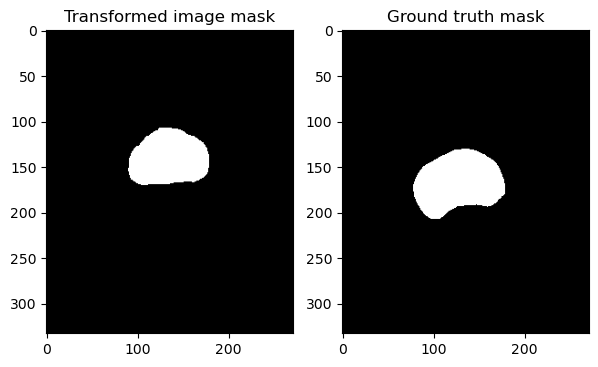

In [84]:
# Read and inspect images
readable_transformed_mask = imageio.imread(transformed_mask)
readable_ground_truth = imageio.imread(ground_truth)
for i in range(50,51):
    fig, ax = plt.subplots(1, 2, figsize=(7, 5))
    ax[0].imshow(readable_transformed_mask[i,:,:], cmap='gray')
    ax[0].set_title('Transformed image mask')
    ax[1].imshow(readable_ground_truth[i,:,:], cmap='gray')
    ax[1].set_title('Ground truth mask')
    plt.show()

In [85]:
# Calculate DICE score
def diceFunction(im1, im2):
    '''
    Compute the dice score between two input images or volumes. Note that we use a smoothing factor of 1.
    :param im1: Image 1
    :param im2: Image 2
    :return: Dice score
    '''
    im1 = np.asarray(im1).astype(bool)
    im2 = np.asarray(im2).astype(bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return (2. * intersection.sum() ) / (im1.sum() + im2.sum())
dice_score= diceFunction(readable_transformed_mask, readable_ground_truth)

dice_score

0.34168448013324393

In [103]:
# Compute Hausdorff distances (and other metrics)

def computeQualityMeasures(lP,lT):
    
    quality=dict()
    labelPred=sitk.GetImageFromArray(lP, isVector=False)
    labelTrue=sitk.GetImageFromArray(lT, isVector=False)
    
    #Hausdorff Distance
    hausdorffcomputer=sitk.HausdorffDistanceImageFilter()
    hausdorffcomputer.Execute(labelTrue>0.5,labelPred>0.5)
    quality["avgHausdorff"]=hausdorffcomputer.GetAverageHausdorffDistance()
    quality["Hausdorff"]=hausdorffcomputer.GetHausdorffDistance()

    
    ##Dice,Jaccard,Volume Similarity..
    #dicecomputer.Execute(labelTrue>0.5,labelPred>0.5)
    #quality["dice"]=dicecomputer.GetDiceCoefficient()
    #quality["volume_similarity"]=dicecomputer.GetVolumeSimilarity()
    #quality["false_negative"]=dicecomputer.GetFalseNegativeError()
    #quality["false_positive"]=dicecomputer.GetFalsePositiveError()
    
    #Surface distance measures
    label = 1
    ref_distance_map=sitk.Abs(sitk.SignedMaurerDistanceMap(labelTrue>0.5,squaredDistance=False))
    ref_surface=sitk.LabelContour(labelTrue>0.5)
    statistics_image_filter=sitk.StatisticsImageFilter()
    statistics_image_filter.Execute(labelTrue>0.5)
    num_ref_surface_pixels=int(statistics_image_filter.GetSum())

    seg_distance_map=sitk.Abs(sitk.SignedMaurerDistanceMap(labelPred>0.5,squaredDistance=False))
    seg_surface=sitk.LabelContour(labelPred>0.5)
    seg2ref_distance_map=ref_distance_map*sitk.Cast(seg_surface,sitk.sitkFloat32)
    ref2seg_distance_map=seg_distance_map*sitk.Cast(ref_surface,sitk.sitkFloat32)
    
    statistics_image_filter.Execute(labelPred>0.5)
    num_seg_surface_pixels=int(statistics_image_filter.GetSum())

    seg2ref_distance_map_arr=sitk.GetArrayViewFromImage(seg2ref_distance_map)
    seg2ref_distances=list(seg2ref_distance_map_arr[seg2ref_distance_map_arr!=0])
    seg2ref_distances=seg2ref_distances+list(np.zeros(num_seg_surface_pixels-len(seg2ref_distances)))
    ref2seg_distance_map_arr=sitk.GetArrayViewFromImage(ref2seg_distance_map)
    ref2seg_distances=list(ref2seg_distance_map_arr[ref2seg_distance_map_arr!=0])
    ref2seg_distances=ref2seg_distances+list(np.zeros(num_ref_surface_pixels-len(ref2seg_distances)))

    all_surface_distances=seg2ref_distances+ref2seg_distances
    #quality["mean_surface_distance"]=np.mean(all_surface_distances)
    #quality["median_surface_distance"]=np.median(all_surface_distances)
    #quality["std_surface_distance"]=np.std(all_surface_distances)
    #quality["max_surface_distance"]=np.max(all_surface_distances)
    
    
    ### Find the distances to surface points of the contour.  Calculate in both directions         
    dist_seg = sitk.GetArrayViewFromImage(seg_distance_map)[sitk.GetArrayViewFromImage(ref_surface)==1]
    dist_ref = sitk.GetArrayViewFromImage(ref_distance_map)[sitk.GetArrayViewFromImage(seg_surface)==1]


    ### Find the 95% Distance for each direction and average        
    quality['hausdorff_95']= (np.percentile(dist_ref, 95) + np.percentile(dist_seg, 95)) / 2.0

    return quality
    
quality = computeQualityMeasures(readable_ground_truth, readable_transformed_mask)
print(quality)


{'avgHausdorff': 7.142422983558485, 'Hausdorff': 45.088801270381985, 'hausdorff_95': 26.938513469696034}


In [72]:
# Not ready yet

# Make a new transformix object tr with the CORRECT PATH to transformix
tr = elastix.TransformixInterface(parameters=transform_path,
                                  transformix_path=TRANSFORMIX_PATH)

# Transform a new image with the transformation parameters
transformed_image_path = tr.transform_image(moving_image_path, output_dir=r'results')

# Get the Jacobian matrix
jacobian_matrix_path = tr.jacobian_matrix(output_dir=r'results')

# Get the Jacobian determinant
jacobian_determinant_path = tr.jacobian_determinant(output_dir=r'results')

# Get the full deformation field
deformation_field_path = tr.deformation_field(output_dir=r'results')

# Add a plot of the Jacobian determinant (in this case, the file is a tiff file)
ax[3].imshow(imageio.imread(jacobian_determinant_path.replace('dcm', 'tiff')))
ax[3].set_title('Jacobian\ndeterminant')

NameError: name 'transform_path' is not defined